In [36]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
import torch_harmonics as th
from torch_harmonics.random_fields import GaussianRandomFieldS2
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import netCDF4

import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO, SFNO
import jaxwt as jwt
import pcax
from jax.scipy.stats import norm, laplace

In [2]:
def phi_depth(z, x, w, depth_fn):
    if depth_fn == 'tukey':
        f = jnp.sum(w[:,None] * (z > x), axis = 0)
        depth_1d = 1 - jnp.abs(1 - 2 * f)
    
    elif depth_fn == 'mahal':
        mu = jnp.sum(w[:,None]*x, axis = 0)
        sig = jnp.sqrt(jnp.sum((w[:,None]*x - mu)**2, axis = 0))
        depth_1d = 1/(1+jnp.sqrt((z - mu)**2/sig**2))
        
    elif depth_fn == 'norm':
        norms = jnp.abs(z - x)
        wnorm = jnp.sum(w[:,None] * norms, axis = 0)
        depth_1d = 1/(1+wnorm)

    else: return 0
    return jnp.min(depth_1d)

phi_depth = jit(phi_depth, static_argnames='depth_fn')
vphi_depth = jit(vmap(phi_depth, (0, None, None, None)), static_argnames='depth_fn')

def phi_slice(rng, p1, p2):
    phi = random.normal(rng, (p1, p2))
    phi = phi / jnp.sum(phi, axis = 1)[:,None]
    return phi

def lweights(xval, xtest, frac = 0.1):
    dmat = jnp.max(jnp.abs(xval - xtest), axis = 1)
    quant = jnp.quantile(dmat, frac, axis = 0)
    indx = dmat < quant
    inner_max = jnp.max(dmat * indx)
    dmat = inner_max - dmat
    w = dmat * indx
    return w / jnp.sum(w, axis = 0)[None,]
lweights = jit(vmap(lweights, (None, 0, None)))

def localizer(xval, xtest, lam, local_fn, self, rng):
    ind = 1 if self else 0
    
    if local_fn == 'dexp':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.max(jnp.abs(xval - xtil), axis = (1, 2))
        # dist = (dist - jnp.min(dist)) / (jnp.max(dist) - jnp.min(dist))
        dist = dist / jnp.max(dist)
        local_weights = dist / (jnp.sum(dist) + ind * jnp.exp(-lam * 1e-2))
        
    elif local_fn == 'gaussian':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.mean((xval - xtil)**2, axis = (1, 2))
        # dist = (dist - jnp.min(dist)) / (jnp.max(dist) - jnp.min(dist))
        dist = dist / jnp.max(dist)
        dist = jnp.exp(-lam * dist)
        local_weights = dist / (jnp.sum(dist) + ind * jnp.exp(-lam * 1e-2))
        
    elif local_fn == 'knn':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.max(jnp.abs(xval - xtil), axis = (1, 2))
        # dist = (dist - jnp.min(dist)) / (jnp.max(dist) - jnp.min(dist))
        dist = dist / jnp.max(dist)
        qdist = jnp.quantile(dist, lam)
        dist = jnp.exp(-dist.at[dist > qdist].set(jnp.inf))
        local_weights = dist / (jnp.sum(dist) + ind * 1)
        
    else :
        local_weights = 1/xval.shape[0]
    return local_weights

def local_quantile(rval_phi, xval, xtest, alpha, depth_fn, local_fn, lam, rng):

    local_weights = localizer(xval, xtest, lam, local_fn, True, rng)
    dval = vphi_depth(rval_phi, rval_phi, local_weights, depth_fn)
    
    n = xval.shape[0]
    adj_alpha = jnp.ceil((n+1)*(1-alpha))/n
    return jnp.quantile(dval, 1-adj_alpha), local_weights

def local_sampler(xval, xtest, rval_phi, n_samp, local_fn, lam, rng):
    
    n = rval_phi.shape[0]
    npc = rval_phi.shape[1]
    local_weights = localizer(xval, xtest, lam, local_fn, False, rng)
    # local_weights = lweights(xval, xtest, 0.1)
    
    unif = random.uniform(rng, (n_samp, npc))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    samp_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    samp_quants = jnp.argmax(samp_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    samp_phi = quants[samp_quants].T
    return samp_phi

In [3]:
def uqno_lambda(yval, yval_hat, yval_quant, delta, alpha):
    n = yval.shape[0]
    m = yval.shape[1]
    tau = 1e-2 + jnp.sqrt(-jnp.log(delta)/(2*m))
    
    uqno_scores = jnp.abs(yval.squeeze() - yval_hat) / yval_quant
    sg = jnp.quantile(uqno_scores, jnp.clip(1-alpha+tau, 0, 1), axis = 1)
    q = 1 - jnp.ceil((n+1)*(delta - jnp.exp(-2*m*tau**2)))/n
    return jnp.quantile(sg, q)

def prob_don(yval, yval_mu, yval_sd, ytest_sd, alpha):
    nval = yval.shape[0]
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/nval
    
    score = jnp.abs(yval - yval_mu)/yval_sd
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -ytest_sd * q[None,]
    upper = ytest_sd * q[None,]
    return lower, upper

def quant_don(yval, yval_quant, ytest_quant, alpha):
    
    nval = yval.shape[0]
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/nval
    
    lower = -yval_quant - yval
    upper = yval - yval_quant
    score = jnp.max(jnp.stack([lower, upper], axis = 2), axis=2)
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -ytest_quant - q[None,]
    upper = ytest_quant + q[None,]
    return lower, upper

In [4]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def forward(self, y_hat, y):
        res = y - y_hat
        return torch.mean(torch.max((self.quantile - 1) * res, self.quantile * res))
    
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, y):
        mu, sd = outputs
        nll = 0.5 * torch.log(2 * torch.pi * sd**2) + 0.5*(y - mu)**2 / sd**2
        return nll.mean()
    
class ProbFNO(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu_fno = FNO(n_modes=(16,32), hidden_channels=64, in_channels=1, out_channels=1)
        self.sd_fno = FNO(n_modes=(16,32), hidden_channels=64, in_channels=1, out_channels=1)

    def __call__(self, x):
        mu = self.mu_fno(x)
        log_sd = self.sd_fno(x)
        return mu, torch.nn.Softplus()(log_sd)

In [5]:
era5_fp = '../data/era5.nc'
era5 = netCDF4.Dataset(era5_fp)
print(era5) 

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    dimensions(sizes): valid_time(1023), latitude(721), longitude(1440)
    variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 t2m(valid_time, latitude, longitude)
    groups: 


In [6]:
ntrain = 400
nval = ntrain + 400

nlat_lr, nlon_lr = 32, 64
nlat_hr, nlon_hr = 256, 512

data_train = era5['t2m'][:ntrain] - 273.15

down_lr = nn.Upsample(size=(nlat_lr, nlon_lr), mode ='bicubic')
down_hr = nn.Upsample(size=(nlat_hr, nlon_hr), mode ='bicubic')

data_train = down_lr(torch.tensor(data_train)[:,None])[:,0]
data_train = torch2jax(data_train.detach())

lag, lead = 1, 1
xtrain, ytrain = split_data(data_train, lag, lead)
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
loss_fn = nn.MSELoss()
epochs = 100

fno = SFNO(n_modes=(16, 32), 
             hidden_channels=128, 
             in_channels=1, 
             out_channels=1)
fno.to(device)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):
        xt = xt.to(device)
        yt = yt.to(device)
        yhat = fno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

fno.eval()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

SFNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SphericalConv(
        (weight): ComplexDenseTensor(shape=torch.Size([128, 128, 16]), rank=None)
        (sht_handle): SHT(
          (_SHT_cache): ModuleDict(
            (32_64_16_16_ortho_equiangular): RealSHT(
              nlat=32, nlon=64,
               lmax=16, mmax=16,
               grid=equiangular, csphase=True
            )
          )
          (_iSHT_cache): ModuleDict(
            (32_64_16_16_ortho_equiangular): InverseRealSHT(
              nlat=32, nlon=64,
               lmax=16, mmax=16,
               grid=equiangular, csphase=True
            )
          )
        )
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(128, 64, 

In [8]:
# lag, lead = 1, 1
# xval, yval = split_data(data_val, lag, lead)
# val_data = TensorDataset(jax2torch(xval), jax2torch(yval))
# val_loader = DataLoader(val-data, batch_size = 16, shuffle = True)

In [9]:
data_val = era5['t2m'][ntrain:nval] - 273.15
data_val = down_lr(torch.tensor(data_val)[:,None])[:,0]
data_val = torch2jax(data_val.detach())

xval, yval = split_data(data_val, lag, lead)
val_data = TensorDataset(jax2torch(xval), jax2torch(yval))
val_loader = DataLoader(val_data, batch_size = 5, shuffle = True)

In [10]:
yval = era5['t2m'][ntrain:nval][1:] - 273.15
yval = down_hr(torch.tensor(yval)[:,None])[:,0]
yval.shape

torch.Size([399, 256, 512])

In [11]:
with torch.no_grad():
    yval_fno = []
    for xt, _ in tqdm(val_loader, leave = False):
        xt = jax2torch(xt).to(device)
        yhat = fno.forward(torch.tensor(xt).to(device), output_shape=(nlat_hr, nlon_hr))
        yhat = torch2jax(yhat[:,0].cpu())
        yval_fno.append(yhat)

  0%|          | 0/80 [00:00<?, ?it/s]

/tmp/ipykernel_149825/845669636.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yhat = fno.forward(torch.tensor(xt).to(device), output_shape=(nlat_hr, nlon_hr))


In [12]:
yval_fno2 = jnp.concat(yval_fno)

In [13]:
rval_fno = jnp.array(yval) - yval_fno2
rval_fno = rval_fno.reshape(399, -1)

In [14]:
data_test = era5['t2m'][nval:] - 273.15
data_test = down_lr(torch.tensor(data_test)[:,None])[:,0]
data_test = torch2jax(data_test.detach())

xtest, ytest = split_data(data_test, lag, lead)

In [15]:
ytest = era5['t2m'][nval:][1:] - 273.15
ytest = down_hr(torch.tensor(ytest)[:,None])[:,0]
yval.shape

torch.Size([399, 256, 512])

In [16]:
del xtrain, ytrain, fno

In [17]:
nproj = 100
nsamp = 100
alpha = 0.1

# setup
pca_state = pcax.fit(rval_fno, nproj)
rval_fpc = pcax.transform(pca_state, rval_fno)

In [18]:
x_state = pcax.fit(xval.reshape(-1, nlat_lr*nlon_lr), nlat_lr*nlon_lr)
xval_fpc = pcax.transform(x_state, xval.reshape(-1, nlat_lr*nlon_lr))[:,None]
xtest_fpc = pcax.transform(x_state, xtest.reshape(-1, nlat_lr*nlon_lr))[:,None]

In [19]:
conf_lower, conf_upper = conf.conf_band(rval_fno, pca_state, alpha)

In [60]:
rng = random.PRNGKey(0)
upper_lsci = []
lower_lsci = []
std_lsci = []
weights = []
for k in trange(120):
    
    rng, key1, key2 = random.split(rng, 3)
    
    phi_samp = local_sampler(xval.reshape(-1, 1, nlat_lr*nlon_lr), 
                             xtest[k].reshape(1, nlat_lr*nlon_lr),
                             rval_fpc, nsamp, 'knn', 0.1, key1)
    
    phi_rec = [pcax.recover(pca_state, a) for a in tqdm(phi_samp, leave = False)]
    phi_samp = jnp.concat(phi_rec)

    phi = phi_slice(key2, nlat_hr*nlon_hr, nproj)
    qval, local_weights = local_quantile(rval_fno @ phi, 
                                         xval.reshape(-1, 1, nlat_lr*nlon_lr),
                                         xtest[k].reshape(1, nlat_lr*nlon_lr),
                                         alpha, 
                                         'tukey', 'gaussian', 1, key2)
    dphi = vphi_depth(phi_samp @ phi, rval_fno @ phi, local_weights, 'tukey')
    local_ens = phi_samp[dphi >= qval]

    weights.append(local_weights)
    upper_lsci.append(np.max(local_ens, axis = 0).reshape(nlat_hr, nlon_hr))
    lower_lsci.append(np.min(local_ens, axis = 0).reshape(nlat_hr, nlon_hr))

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
# d = jnp.sqrt(jnp.mean((xval_fpc - xtest_fpc[k][None,])**2, axis = (1, 2)))
# d = (d - jnp.min(d)) / (jnp.max(d) - jnp.min(d))
# d = jnp.exp(-d)
# d = d/jnp.sum(d)

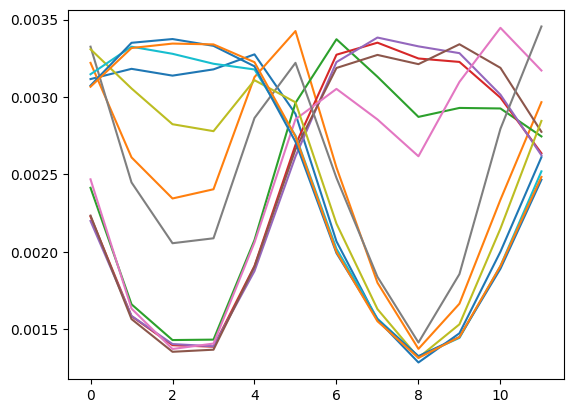

In [62]:
for i in range(12):
    plt.plot(weights[i][0:12])

In [64]:
# fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize = (9, 5))

# k = 0
# im1 = ax[0,0].imshow(std_lsci[0], cmap = 'RdBu_r')
# im2 = ax[1,0].imshow(std_lsci[1], cmap = 'RdBu_r')
# im3 = ax[0,1].imshow(std_lsci[2], cmap = 'RdBu_r')
# im4 = ax[1,1].imshow(std_lsci[3], cmap = 'RdBu_r')

In [65]:
# plt.imshow(yval_fno2[0])

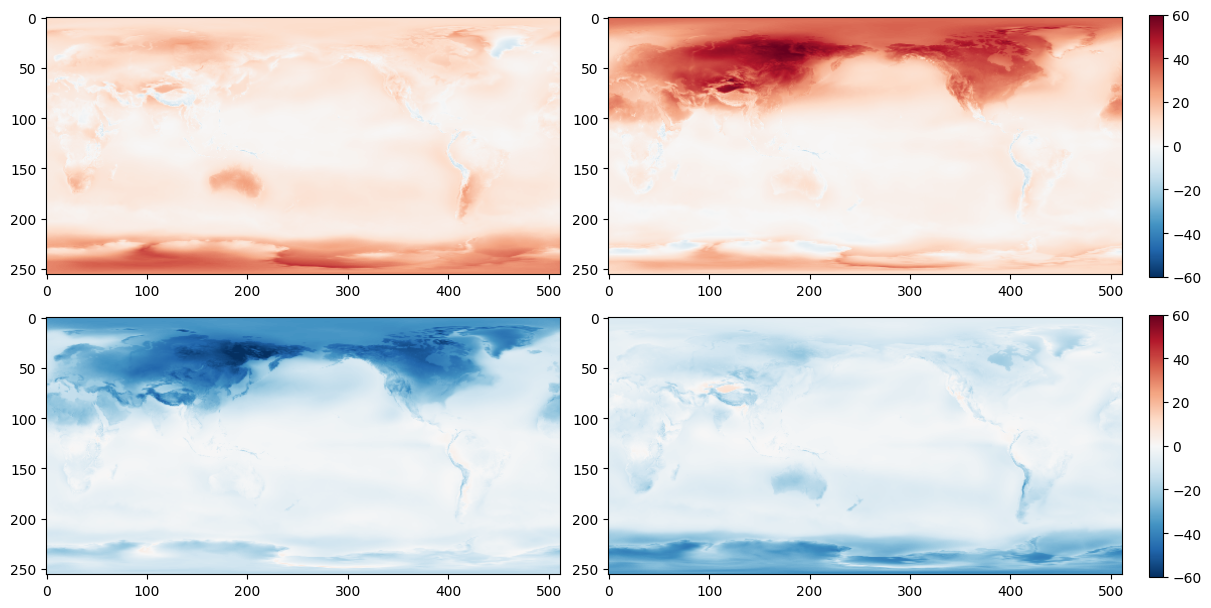

In [70]:
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize = (12, 6))

im1 = ax[0,0].imshow(upper_lsci[3], cmap = 'RdBu_r', vmin = -60, vmax = 60)
im2 = ax[1,0].imshow(lower_lsci[3], cmap = 'RdBu_r', vmin = -60, vmax = 60)
im3 = ax[0,1].imshow(upper_lsci[9], cmap = 'RdBu_r', vmin = -60, vmax = 60)
im4 = ax[1,1].imshow(lower_lsci[9], cmap = 'RdBu_r', vmin = -60, vmax = 60)

fig.colorbar(im3, ax = ax[0,1])
fig.colorbar(im4, ax = ax[1,1])
plt.show()

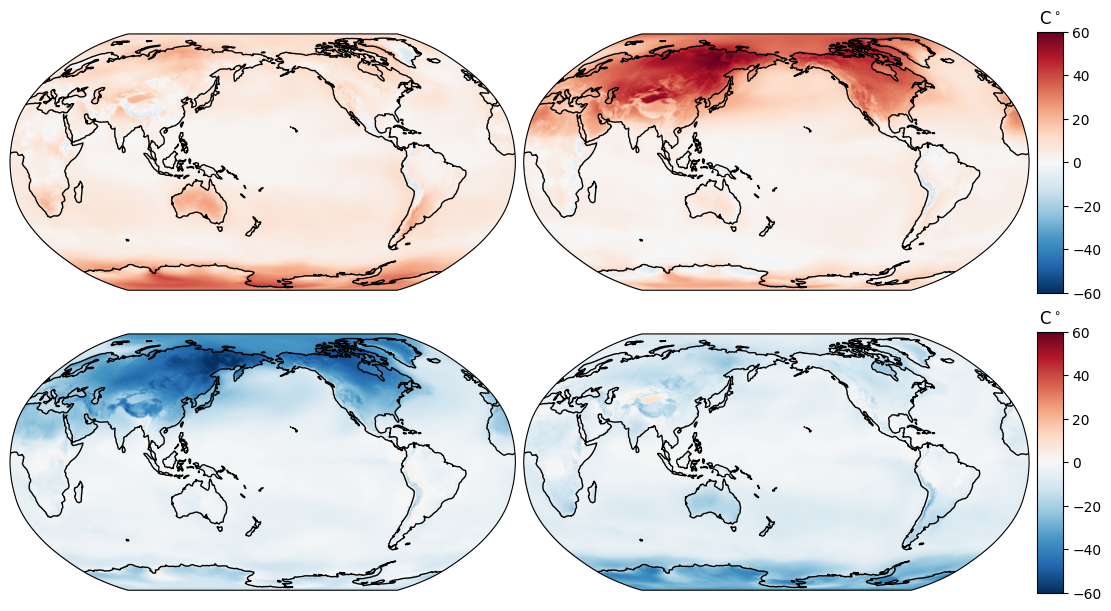

In [68]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (11, 6))
gs = GridSpec(2, 3, width_ratios = [1, 1, 0.05], figure = fig)

dates = ['Jan 1st, 1959', 'Jan 2nd, 1959', 'Jan 3rd, 1959']

ax = plt.subplot(gs[0,0], projection = plot_crs)
im = ax.imshow(upper_lsci[3], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
# ax.set_title(dates[i], fontsize = 18)

ax = plt.subplot(gs[1,0], projection = plot_crs)
im1 = ax.imshow(lower_lsci[3], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
# ax.set_title(dates[i], fontsize = 18)

ax = plt.subplot(gs[0,1], projection = plot_crs)
im = ax.imshow(upper_lsci[9], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
# ax.set_title(dates[i], fontsize = 18)

ax = plt.subplot(gs[1,1], projection = plot_crs)
im2 = ax.imshow(lower_lsci[9], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
# ax.set_title(dates[i], fontsize = 18)

ax = plt.subplot(gs[0,-1])
ax.set_title('C$^\\circ$')
plt.colorbar(im1, cax = ax)

ax = plt.subplot(gs[1,-1])
ax.set_title('C$^\\circ$')
plt.colorbar(im1, cax = ax)
plt.show()

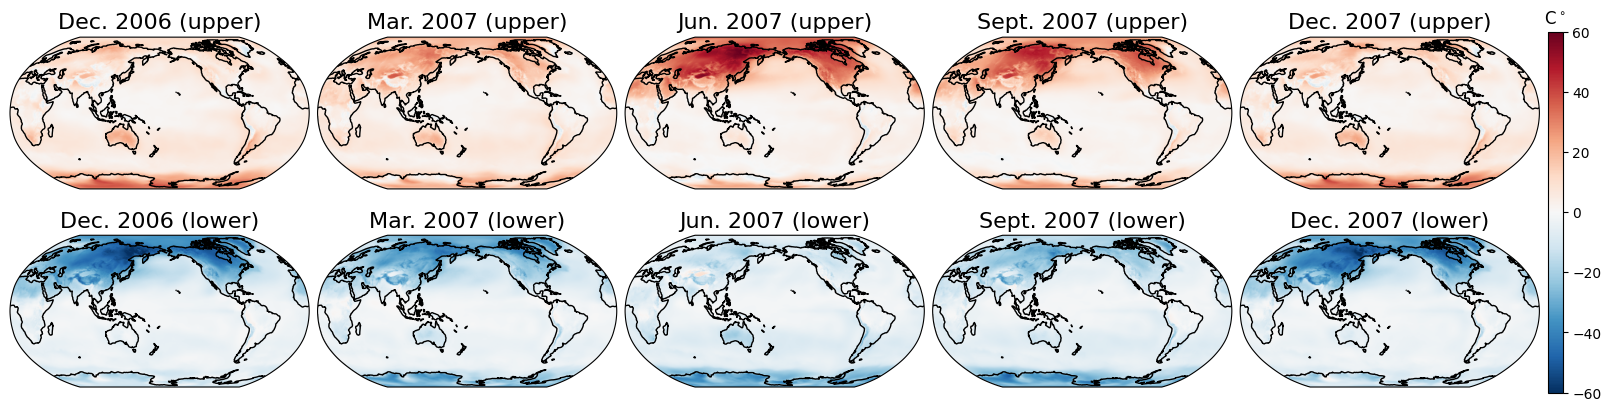

In [98]:
data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (16, 4))
gs = GridSpec(2, 6, width_ratios = [1, 1, 1, 1, 1, 0.05], figure = fig)

upper_titles = ['Dec. 2006 (upper)', 
                'Mar. 2007 (upper)', 
                'Jun. 2007 (upper)',
                'Sept. 2007 (upper)', 
                'Dec. 2007 (upper)']

lower_titles = ['Dec. 2006 (lower)', 
                'Mar. 2007 (lower)', 
                'Jun. 2007 (lower)',
                'Sept. 2007 (lower)', 
                'Dec. 2007 (lower)']


ax = plt.subplot(gs[0,0], projection = plot_crs)
im = ax.imshow(upper_lsci[3], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(upper_titles[0], fontsize = 16)

ax = plt.subplot(gs[1,0], projection = plot_crs)
im1 = ax.imshow(lower_lsci[3], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(lower_titles[0], fontsize = 16)

ax = plt.subplot(gs[0,1], projection = plot_crs)
im = ax.imshow(upper_lsci[6], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(upper_titles[1], fontsize = 16)

ax = plt.subplot(gs[1,1], projection = plot_crs)
im2 = ax.imshow(lower_lsci[6], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(lower_titles[1], fontsize = 16)

ax = plt.subplot(gs[0,2], projection = plot_crs)
im = ax.imshow(upper_lsci[9], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(upper_titles[2], fontsize = 16)

ax = plt.subplot(gs[1,2], projection = plot_crs)
im1 = ax.imshow(lower_lsci[9], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(lower_titles[2], fontsize = 16)

ax = plt.subplot(gs[0,3], projection = plot_crs)
im = ax.imshow(upper_lsci[12], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(upper_titles[3], fontsize = 16)

ax = plt.subplot(gs[1,3], projection = plot_crs)
im2 = ax.imshow(lower_lsci[12], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(lower_titles[3], fontsize = 16)

ax = plt.subplot(gs[0,4], projection = plot_crs)
im = ax.imshow(upper_lsci[15], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(upper_titles[4], fontsize = 16)

ax = plt.subplot(gs[1,4], projection = plot_crs)
im2 = ax.imshow(lower_lsci[15], cmap = 'RdBu_r', transform = data_crs, vmin = -60, vmax = 60)
ax.coastlines()
ax.set_title(lower_titles[4], fontsize = 16)

ax = plt.subplot(gs[0:2,-1])
ax.set_title('C$^\\circ$')
plt.colorbar(im1, cax = ax)

# ax = plt.subplot(gs[1,-1])
# ax.set_title('C$^\\circ$')
# plt.colorbar(im1, cax = ax)
fig.savefig('../weather/climate_bands.png')
plt.show()

In [97]:
!pwd

/home/tharris/LSCI/gpsims


/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [298]:
# loss_fn = QuantileLoss(0.9)

# fno_quant = FNO(n_modes=(16,32), 
#              hidden_channels=64, 
#              in_channels=1, 
#              out_channels=1)
# fno_quant.to(device)
# optim_fno = torch.optim.Adam(fno_quant.parameters(), lr = 1e-3)

# for _ in trange(epochs):
#     for xt, yt in tqdm(train_loader, leave = False):
#         xt = xt.to(device)
#         yt = yt.to(device)
#         yhat = fno_quant(xt)
#         loss = loss_fn(yhat, yt)
#         loss.backward()
#         optim_fno.step()
#         optim_fno.zero_grad()

In [11]:
# loss_fn = GaussianNLLLoss()

# fno_prob = ProbFNO()
# fno_prob.to(device)
# optim_fno = torch.optim.Adam(fno_prob.parameters(), lr = 1e-3)

# for _ in trange(epochs):
#     for xt, yt in tqdm(train_loader, leave = False):
#         xt = xt.to(device)
#         yt = yt.to(device)
#         yhat = fno_prob(xt)
#         loss = loss_fn(yhat, yt)
#         loss.backward()
#         optim_fno.step()
#         optim_fno.zero_grad()

In [17]:
# n = xtrain.shape[0]
# xtrain_base1 = xtrain[:(n//2)]
# ytrain_base1 = ytrain[:(n//2)]
# xtrain_base2 = xtrain[(n//2):]
# ytrain_base2 = ytrain[(n//2):]

# train_data1 = TensorDataset(jax2torch(xtrain_base1), jax2torch(ytrain_base1))
# train_loader1 = DataLoader(train_data1, batch_size = 30, shuffle = True)

# train_data2 = TensorDataset(jax2torch(xtrain_base2), jax2torch(ytrain_base2))
# train_loader2 = DataLoader(train_data2, batch_size = 30, shuffle = False)

In [12]:
# loss_fn = nn.MSELoss()
# fno_base = FNO(n_modes=(16,32), 
#              hidden_channels=64, 
#              in_channels=1, 
#              out_channels=1)
# fno_base.to(device)
# optim_fno = torch.optim.Adam(fno_base.parameters(), lr = 1e-3)

# for _ in trange(epochs):
#     for xt, yt in tqdm(train_loader1, leave = False):
#         xt = xt.to(device)
#         yt = yt.to(device)
#         yhat = fno_base(xt)
#         loss = loss_fn(yhat, yt)
#         loss.backward()
#         optim_fno.step()
#         optim_fno.zero_grad()

In [19]:
# ytrain_base1_hat = []
# with torch.no_grad():
#     for xt, yt in tqdm(train_loader2, leave = False):
#         yt_hat = fno_base(xt.to(device)).cpu().squeeze()
        
#         ytrain_base1_hat.append(yt_hat)
# ytrain_base1_hat = torch.vstack(ytrain_base1_hat)[:,None]
# ytrain_base1_hat = torch2jax(ytrain_base1_hat)

# train_data2 = TensorDataset(jax2torch(xtrain_base2), torch.abs(jax2torch(ytrain_base2 - ytrain_base1_hat)))
# train_loader2 = DataLoader(train_data2, batch_size = 30, shuffle = True)

  0%|          | 0/61 [00:00<?, ?it/s]

In [20]:
# loss_fn = QuantileLoss(0.9)
# fno_quant2 = FNO(n_modes=(16,32), 
#              hidden_channels=64, 
#              in_channels=1, 
#              out_channels=1)
# fno_quant2.to(device)
# optim_fno = torch.optim.Adam(fno_quant2.parameters(), lr = 1e-3)

# epochs = 20
# for _ in trange(epochs):
#     for xt, yt in tqdm(train_loader2, leave = False): 
#         xt = xt.to(device)
#         yt = yt.to(device)
#         yhat = fno_quant2(xt)
#         loss = loss_fn(yhat, yt)
#         loss.backward()
#         optim_fno.step()
#         optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [39]:
# del dtrain, xtrain, ytrain
dval = np.load('../data/era5_val_small.npy', mmap_mode='r+')
# dtest = np.load('../data/era5_test_small.npy', mmap_mode='r+')

dval = np.mean(dval.reshape(-1, 4, nlat, nlon), axis = 1)
# dtest = np.mean(dtest.reshape(-1, 4, nlat, nlon), axis = 1)

dval = np.array(clim_smooth(dval, kernel))
# dtest = np.array(clim_smooth(dtest, kernel))

# dval = (dval - spatial_mean)/spatial_std
# dtest = (dtest - spatial_mean)/spatial_std

xval, yval = split_data(dval, lag, lead)
# xtest, ytest = split_data(dtest, lag, lead)

In [40]:
val_data = TensorDataset(jax2torch(xval), jax2torch(yval))
val_loader = DataLoader(val_data, batch_size = 30, shuffle = True)

# test_data = TensorDataset(jax2torch(xtest), jax2torch(ytest))
# test_loader = DataLoader(test_data, batch_size = 30, shuffle = False)

In [41]:
with torch.no_grad():
    yval_fno = []
    # yval_quant = []
    # yval_mu = []
    # yval_sd = []
    # yval_hat2 = []
    # yval_quant2 = []

    # ytest_fno = []
    # ytest_quant = []
    # ytest_mu = []
    # ytest_sd = []
    # ytest_hat2 = []
    # ytest_quant2 = []
    
    for xt, _ in tqdm(val_loader, leave = False):
        xt = jax2torch(xt).to(device)
        
        yval_fno.append(fno(xt).cpu().squeeze())
        # yval_quant.append(fno_quant(xt).cpu().squeeze())
        # yval_mut, yval_sdt = fno_prob(xt)
        # yval_mu.append(yval_mut.cpu().squeeze())
        # yval_sd.append(yval_sdt.cpu().squeeze())
        # yval_hat2.append(fno_base(xt).cpu().squeeze())
        # yval_quant2.append(fno_quant2(xt).cpu().squeeze())
        
    yval_fno = torch2jax(torch.vstack(yval_fno)[:,None])
    # yval_quant = torch2jax(torch.vstack(yval_quant)[:,None])
    # yval_mu = torch2jax(torch.vstack(yval_mu)[:,None])
    # yval_sd = torch2jax(torch.vstack(yval_sd)[:,None])
    # yval_hat2 = torch2jax(torch.vstack(yval_hat2)[:,None])
    # yval_quant2 = torch2jax(torch.vstack(yval_quant2)[:,None])

    # for xt, _ in tqdm(test_loader, leave = False):
    #     xt = jax2torch(xt).to(device)
        
    #     ytest_fno.append(fno(xt).cpu().squeeze())
    #     ytest_quant.append(fno_quant(xt).cpu().squeeze())
    #     ytest_mut, ytest_sdt = fno_prob(xt)
    #     ytest_mu.append(ytest_mut.cpu().squeeze())
    #     ytest_sd.append(ytest_sdt.cpu().squeeze())
    #     ytest_hat2.append(fno_base(xt).cpu().squeeze())
    #     ytest_quant2.append(fno_quant2(xt).cpu().squeeze())

    # ytest_fno = torch2jax(torch.vstack(ytest_fno)[:,None])
    # ytest_quant = torch2jax(torch.vstack(ytest_quant)[:,None])
    # ytest_mu = torch2jax(torch.vstack(ytest_mu)[:,None])
    # ytest_sd = torch2jax(torch.vstack(ytest_sd)[:,None])
    # ytest_hat2 = torch2jax(torch.vstack(ytest_hat2)[:,None])
    # ytest_quant2 = torch2jax(torch.vstack(ytest_quant2)[:,None])

rval_fno = yval - yval_fno
# rtest_fno = ytest - ytest_fno
# rtest_fno2 = ytest - ytest_hat2
# rtest_mu = ytest - ytest_mu
# _, nlat, nlon = rval_fno.shape

  0%|          | 0/61 [00:00<?, ?it/s]

In [42]:
rval_fno = rval_fno.reshape(-1, nlat*nlon)
# rtest_fno = rtest_fno.reshape(-1, nlat*nlon)
# rtest_fno2 = rtest_fno2.reshape(-1, nlat*nlon)
# rtest_mu = rtest_mu.reshape(-1, nlat*nlon)

# yval_quant = yval_quant.reshape(-1, nlat*nlon)
# yval_hat2 = yval_hat2.reshape(-1, nlat*nlon)
# yval_quant2  = yval_quant2.reshape(-1, nlat*nlon)
# ytest_quant2  = ytest_quant2.reshape(-1, nlat*nlon)

yval = yval.reshape(-1, nlat*nlon)
# yval_mu = yval_mu.reshape(-1, nlat*nlon)
# yval_sd = yval_sd.reshape(-1, nlat*nlon)
# ytest_mu  = ytest_mu.reshape(-1, nlat*nlon)
# ytest_sd  = ytest_sd.reshape(-1, nlat*nlon)
# ytest_quant  = ytest_quant.reshape(-1, nlat*nlon)

In [44]:
nproj = nlat*nlon
nslice = nproj
nsamp = 2000
alpha = 0.1

# setup
pca_state = pcax.fit(rval_fno, nproj)
phi = phi_slice(random.PRNGKey(0), rval_fno.shape[1], nproj)
rval_phi = rval_fno @ phi
rval_fpc = pcax.transform(pca_state, rval_fno)

# rval_quant = jnp.abs(rval_fno) / yval_quant

In [45]:
conf_lower, conf_upper = conf.conf_band(rval_fno, pca_state, alpha)
# gaus_lower, gaus_upper = gaus.gaus_band(rval_fno, pca_state, alpha)
# supr_lower, supr_upper = supr.supr_band(rval_fno, alpha)

# uqno_lam = uqno_lambda(yval, yval_hat2, yval_quant2, delta = 0.1, alpha = 0.1)
# uqn1_lower, uqn1_upper = -uqno_lam*ytest_quant2, uqno_lam*ytest_quant2

In [46]:
# pdon_lower, pdon_upper = prob_don(yval.squeeze(), yval_mu, yval_sd, ytest_sd, alpha)
# qdon_lower, qdon_upper = quant_don(yval.squeeze(), yval_quant, ytest_quant, alpha)

In [48]:
x_state = pcax.fit(xval.reshape(-1, nlat*nlon), 5)
xval_fpc = pcax.transform(x_state, xval.reshape(-1, nlat*nlon))
# xtest_fpc = pcax.transform(x_state, xtest.reshape(-1, nlat*nlon))

In [49]:
import zarr
import xarray as xr

obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
era5 = xr.open_zarr(obs_path)

In [55]:
ntest = 20
data_test = era5['temperature'][-ntest:,-1]
time_test = era5['time'][-ntest:]

dtest = np.array(data_test)
dtest = dtest - 273.15

dtest = np.moveaxis(dtest, 1, 2)
dtest = np.rot90(dtest, k = 2, axes = (1, 2))
dtest = np.flip(dtest, axis = 2)

In [56]:
dtest.shape

(20, 32, 64)

In [344]:
rng = random.PRNGKey(0)
ntest = ytest.shape[0]
nmod = 2 + 6
cover = np.zeros((ntest, nmod))
width = np.zeros((ntest, nmod))

lat_weights = np.cos(np.linspace(-np.pi/2, np.pi/2, 32))
lat_weights = lat_weights/np.mean(lat_weights)

for k in trange(ntest):
    
    ## LSCI 1
    dphi_max = 0
    while dphi_max == 0:
        rng, key1, key2 = random.split(rng, 3)
        local_ens, dphi, qval = phi_resample(xval.reshape(-1, 1, nlat*nlon), 
                                             xtest[k].reshape(1, nlat*nlon),
                                             rval_fpc, 
                                             nsamp, nslice, key1,
                                             alpha, 'tukey', 'dexp', 5)
        dphi_max = jnp.sum(dphi > qval)
        local_ens = pcax.recover(pca_state, local_ens)
        local_ens = local_ens[dphi > qval]

    uval = jnp.quantile(local_ens, 0.95, axis = 0)
    lval = jnp.quantile(local_ens, 0.05, axis = 0)
    cover[k, 0] = risk(lval, uval, rtest_fno[k])
    width[k, 0] = np.mean((uval - lval).reshape(nlat, nlon) * lat_weights[:,None])
    
    ## LSCI 2
    dphi_max = 0
    while dphi_max == 0:
        rng, key1, key2 = random.split(rng, 3)
        local_ens, dphi, qval = phi_resample(xval.reshape(-1, 1, nlat*nlon), 
                                             xtest[k].reshape(1, nlat*nlon), 
                                             rval_fpc, 
                                             nsamp, nslice, key2,
                                             alpha, 'tukey', 'knn', 0.2)
        dphi_max = jnp.sum(dphi > qval)
        local_ens = pcax.recover(pca_state, local_ens)
        local_ens = local_ens[dphi > qval]

    uval = jnp.quantile(local_ens, 0.95, axis = 0)
    lval = jnp.quantile(local_ens, 0.05, axis = 0)
    
    cover[k, 1] = risk(lval, uval, rtest_fno[k])
    width[k, 1] = np.mean((uval - lval).reshape(nlat, nlon) * lat_weights[:,None])

    # CONF 
    cover[k, 2] = risk(conf_lower, conf_upper, rtest_fno[k])
    width[k, 2] = jnp.mean((conf_upper - conf_lower).reshape(nlat, nlon) * lat_weights[:,None])
    
    # GAUSS 
    cover[k, 3] = risk(gaus_lower, gaus_upper, rtest_fno[k])
    width[k, 3] = jnp.mean((gaus_upper - gaus_lower).reshape(nlat, nlon) * lat_weights[:,None])
    
    # SUPR
    cover[k, 4] = risk(supr_lower, supr_upper, rtest_fno[k])
    width[k, 4] = jnp.mean((supr_upper - supr_lower).reshape(nlat, nlon) * lat_weights[:,None])
    
    # UQNO
    cover[k, 5] = risk(uqn1_lower[k], uqn1_upper[k], rtest_fno2[k])
    width[k, 5] = jnp.mean((uqn1_upper[k] - uqn1_lower[k]).reshape(nlat, nlon) * lat_weights[:,None])
    
    # PDON
    cover[k, 6] = risk(pdon_lower[k], pdon_upper[k], rtest_mu[k])
    width[k, 6] = jnp.mean((pdon_upper[k] - pdon_lower[k]).reshape(nlat, nlon) * lat_weights[:,None])
    
    # QDON
    cover[k, 7] = risk(qdon_lower[k], qdon_upper[k], rtest_fno[k])
    width[k, 7] = jnp.mean((qdon_upper[k] - qdon_lower[k]).reshape(nlat, nlon) * lat_weights[:,None])

  0%|          | 0/1824 [00:00<?, ?it/s]

E0427 14:40:02.548966   43475 hlo_lexer.cc:443] Failed to parse int literal: 75240990185135123469173


KeyboardInterrupt: 

In [345]:
np.mean(cover[0:1138] > 0.99, axis = 0)

array([0.98154657, 0.96221441, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.37258348])

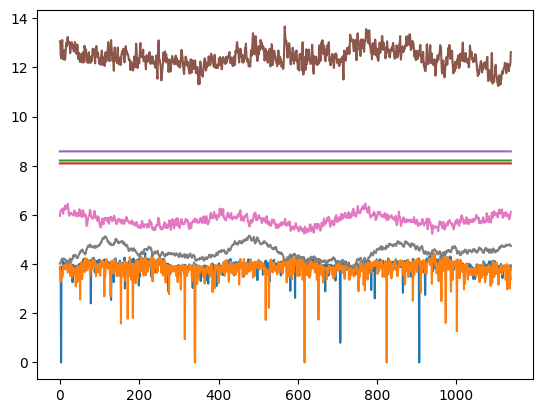

In [346]:
plt.plot(width[0:1138])
plt.show()

In [348]:
np.mean(width[0:1138], axis = 0)

array([ 3.92755036,  3.80552941,  8.21270943,  8.09553432,  8.58407784,
       12.41001385,  5.7896273 ,  4.50340055])

In [349]:
def phi_resample2(xval, xtest, rval_fno, n_samp, n_slice, rng,
                 alpha, depth_fn, local_fn, lam):
    n = rval_fno.shape[0]
    npc = rval_fno.shape[1]//2
    key1, key2, key3 = random.split(rng, 3)

    # renormalize
    xval = xval / jnp.sqrt(jnp.mean(xval**2, axis = 0))
    xtest = xtest / jnp.sqrt(jnp.mean(xtest**2, axis = 0))
    local_weights = lweights(xval.squeeze(), xtest.squeeze()[None,], 0.1)[0]

    # generate
    pca_state = pcax.fit(rval_fno, npc)
    rval_fpc = pcax.transform(pca_state, rval_fno)
    # print(rval_fpc.shape)

    unif = random.uniform(key1, (n_samp, npc))
    quants = jnp.linspace(jnp.min(rval_fpc) - 0.1, jnp.max(rval_fpc) + 0.1, n+1)

    samp_cdfs = lsci.lcdf(rval_fpc, quants, local_weights / jnp.sum(local_weights))
    # print(samp_cdfs.shape)
    samp_quants = jnp.argmax(samp_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    samp_phi = quants[samp_quants].T

    # print(samp_phi.shape)
    samp_phi = pcax.recover(pca_state, samp_phi)

    # check inclusion
    phi = phi_slice(key2, nlat*nlon, n_slice)
    qval, local_weights = phi_quantile(rval_fno @ phi, xval, xtest, alpha, depth_fn, local_fn, lam, rng = key3)
    dphi = vphi_depth(samp_phi @ phi, rval_fno @ phi, local_weights, depth_fn)
    
    return samp_phi, dphi, qval

In [306]:
rval_fno.reshape(-1, nlat*nlon).shape

(1824, 2048)

In [321]:
## LSCI 1
k = 200
dphi_max = 0
while dphi_max == 0:
    rng, key1, key2 = random.split(rng, 3)
    local_ens, dphi, qval = phi_resample2(xval.reshape(-1, 1, nlat*nlon), 
                                         xtest[k].reshape(1, nlat*nlon),
                                         rval_fno.reshape(-1, nlat*nlon), 
                                         nsamp, nslice, key1,
                                         alpha, 'tukey', 'dexp', 5)
    dphi_max = jnp.sum(dphi > qval)

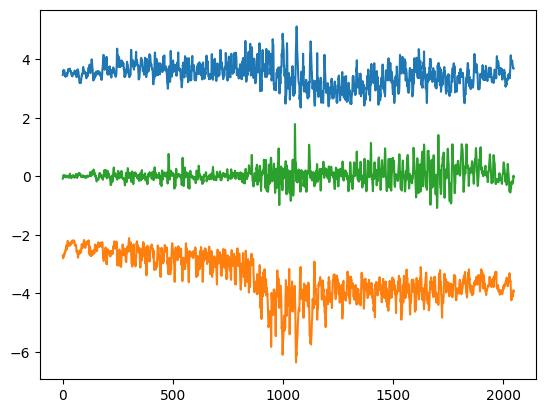

In [327]:
uval = jnp.quantile(local_ens, 0.95, axis = 0)
lval = jnp.quantile(local_ens, 0.05, axis = 0)

plt.plot(uval)
plt.plot(lval)
plt.plot(rtest_fno[k])
plt.show()

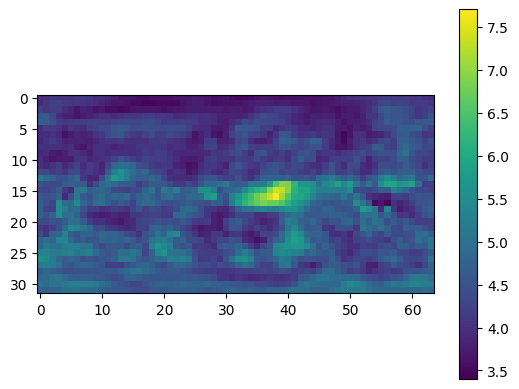

In [259]:
plt.imshow(jnp.abs(uval-lval).reshape(nlat, nlon))
plt.colorbar()
plt.show()

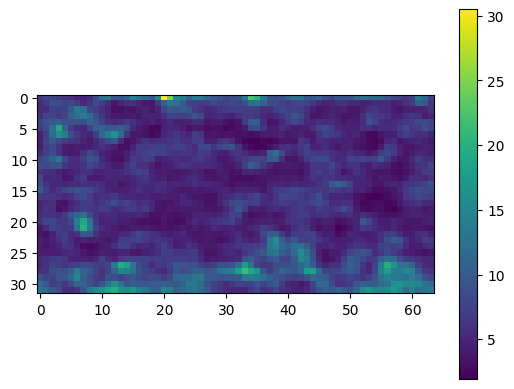

In [206]:
plt.imshow(jnp.abs(pdon_upper[k] - pdon_lower[k]).reshape(nlat, nlon))
plt.colorbar()
plt.show()

In [353]:
cover = cover[0:1138]
width = width[0:1138]

In [355]:
# metrics
# sigma = sd[1:
sigma = jnp.mean(rtest_fno[0:1138]**2, axis = 1)
cover_mean = np.round(np.mean(cover > 0.99, axis = 0), 3)
width_mean = np.round(np.mean(width, axis = 0), 3)

## correlations
cover_corr_mean = np.zeros(nmod)
cover_corr_std = np.zeros(nmod)
width_corr_mean = np.zeros(nmod)
width_corr_std = np.zeros(nmod)
for i in range(nmod):
    corr = np.corrcoef(np.vstack([cover[:,i] > 0.99, sigma]))[0,1]
    cover_corr_mean[i] = np.mean(corr)
#     cover_corr_std[i] = 2*np.std(corr)
    
    corr = np.corrcoef(np.vstack([width[:,i], sigma]))[0,1]
    width_corr_mean[i] = np.mean(corr)
    width_corr_std[i] = 2*np.std(corr)

metrics_mean = np.vstack([
    cover_mean,
    cover_corr_mean,
    width_mean,
    width_corr_mean
]).T

/home/tharris/climate/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tharris/climate/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [356]:
for i in range(nmod):
    for j in range(4):
        spacer = '& ' if j < 3 else '\\\\'
        endline = '' if j < 3 else '\n'
        
        result = metrics_mean[i, j]
        met = f'{result:.3f}' if not np.isnan(result) else '--'
        print(met, spacer, end=endline)

0.982 & -0.003 & 3.928 & 0.177 \\
0.962 & 0.005 & 3.806 & 0.140 \\
1.000 & -- & 8.213 & -- \\
1.000 & -- & 8.096 & -- \\
1.000 & -- & 8.584 & -- \\
1.000 & -- & 12.410 & 0.147 \\
1.000 & -- & 5.790 & -0.365 \\
0.373 & -0.413 & 4.503 & 0.015 \\
